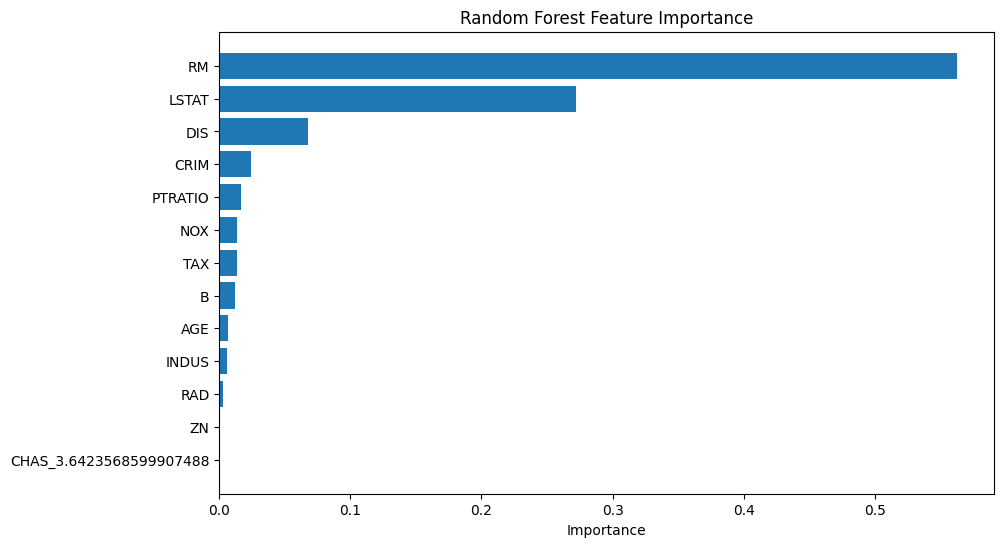

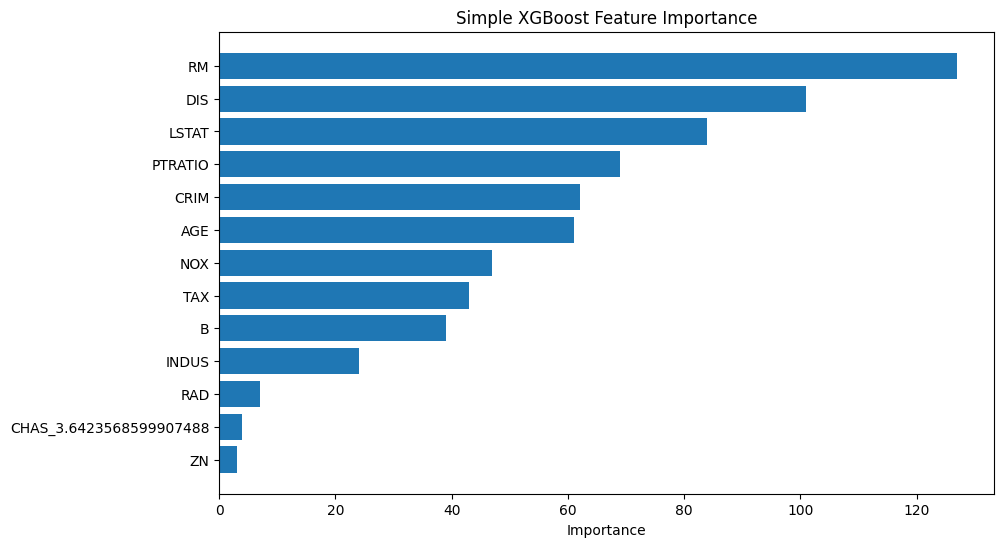

Random Forest RMSE: 0.30977403269661513
Random Forest R²: 0.8144228695193723
Simple XGBoost RMSE: 0.318350803683577
Simple XGBoost R²: 0.8040043930326412


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Load and preprocess the dataset
df = pd.read_csv('datasets/HousingData.csv')

# Normalize numerical features
def normalizedata(x, numerical_cols):
    standardized_x = x.copy()
    for col in numerical_cols:
        standardized_x[col] = (x[col] - x[col].mean()) / x[col].std()
    return standardized_x

num_col = df.select_dtypes(include='float64').columns.tolist()
df[num_col] = normalizedata(df[num_col], num_col)

# One-hot encode categorical column
df = pd.get_dummies(df, columns=['CHAS'], drop_first=True)

# Drop missing values
df = df.dropna()

# 2. Split into X and y
X = df.drop('MEDV', axis=1).values
y = df['MEDV'].values

# 3. Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Define SimpleXGBoostRegressor
class SimpleXGBoostRegressor:
    def __init__(self, n_estimators=10, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.base_prediction = None

    def fit(self, X, y):
        self.base_prediction = np.mean(y)
        y_pred = np.full_like(y, self.base_prediction, dtype=float)

        for _ in range(self.n_estimators):
            residuals = y - y_pred
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)
            update = tree.predict(X)
            y_pred += self.learning_rate * update
            self.trees.append(tree)

    def predict(self, X):
        y_pred = np.full(X.shape[0], self.base_prediction)
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred

# 5. Feature importance for RandomForest
def rf_feature_importance(model, feature_names):
    importances = model.feature_importances_
    return dict(zip(feature_names, importances))

# 6. Approximate feature importance for SimpleXGBoost
def simple_xgb_feature_importance(model, feature_names):
    feature_counts = {name: 0 for name in feature_names}
    for tree in model.trees:
        for i in tree.tree_.feature:
            if i != -2:  # -2 means it's a leaf node
                feature_counts[feature_names[i]] += 1
    return feature_counts

# 7. Plot feature importance
def plot_feature_importance(importance_dict, title):
    features = list(importance_dict.keys())
    values = list(importance_dict.values())
    sorted_indices = np.argsort(values)[::-1]
    features = [features[i] for i in sorted_indices]
    values = [values[i] for i in sorted_indices]
    plt.figure(figsize=(10, 6))
    plt.barh(features, values)
    plt.xlabel("Importance")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# 8. Train models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

xgb_model = SimpleXGBoostRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
xgb_model.fit(X_train, y_train)

# 9. Feature importances
feature_names = df.drop('MEDV', axis=1).columns.tolist()
rf_importance = rf_feature_importance(rf, feature_names)
xgb_importance = simple_xgb_feature_importance(xgb_model, feature_names)

# 10. Plot feature importances
plot_feature_importance(rf_importance, "Random Forest Feature Importance")
plot_feature_importance(xgb_importance, "Simple XGBoost Feature Importance")

# 11. Evaluate on test set
rf_preds = rf.predict(X_test)
xgb_preds = xgb_model.predict(X_test)

print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_preds)))
print("Random Forest R²:", r2_score(y_test, rf_preds))
print("Simple XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, xgb_preds)))
print("Simple XGBoost R²:", r2_score(y_test, xgb_preds))


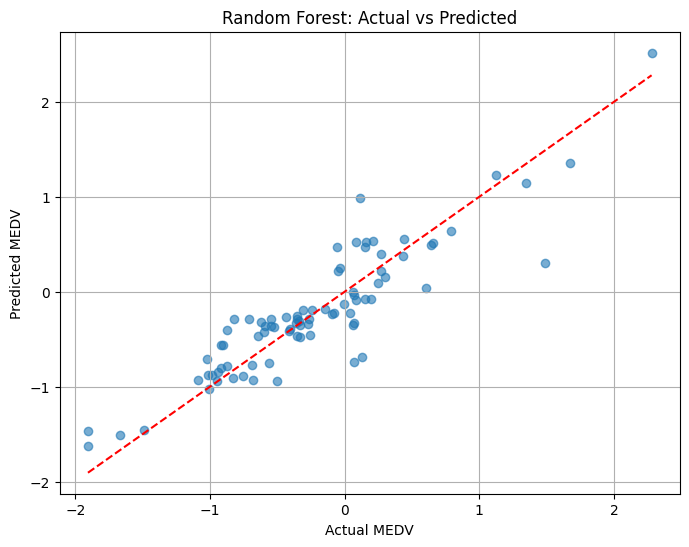

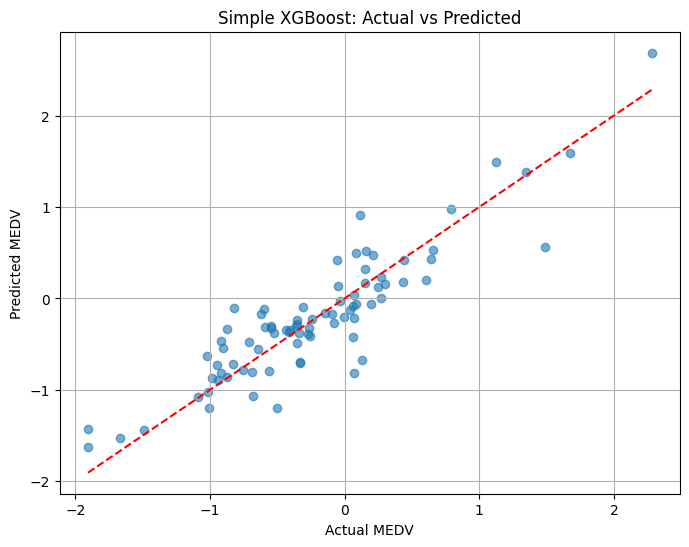

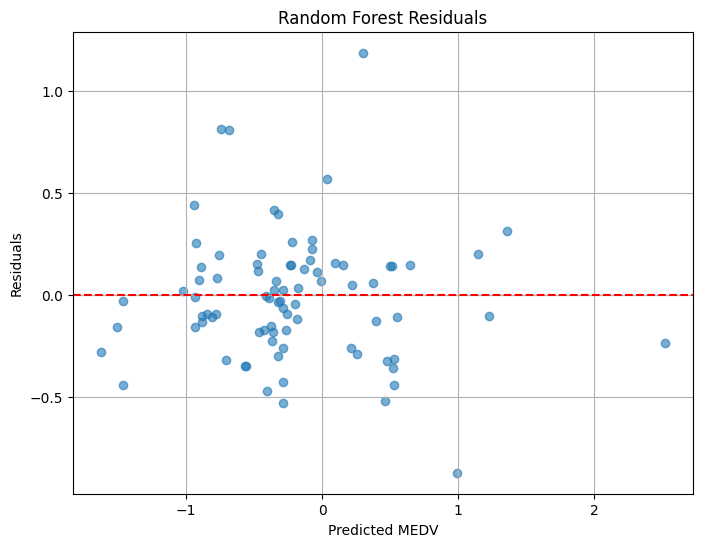

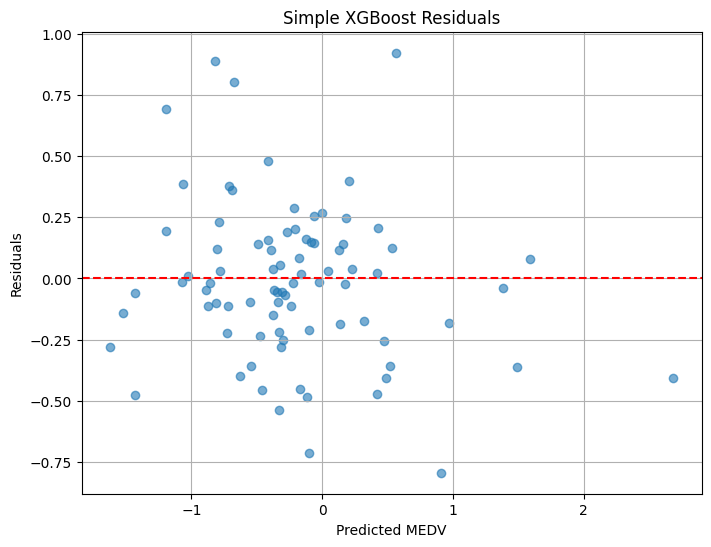

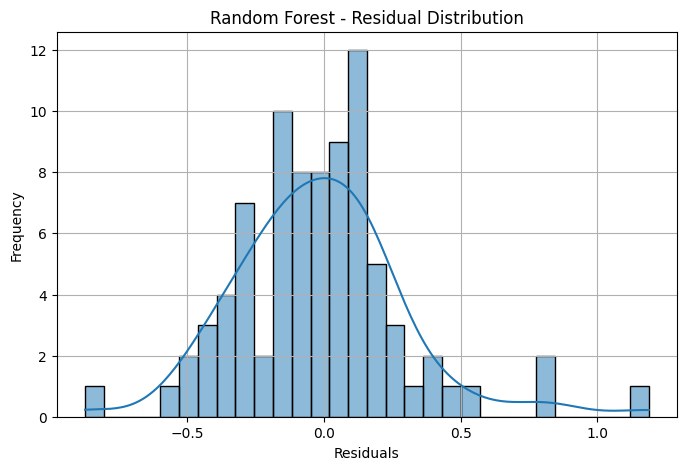

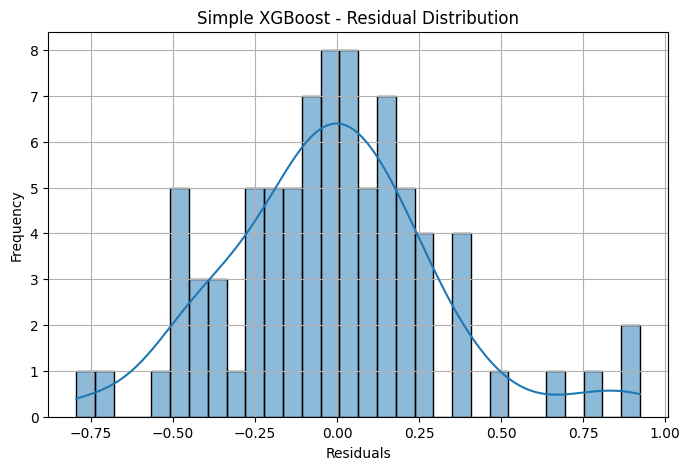

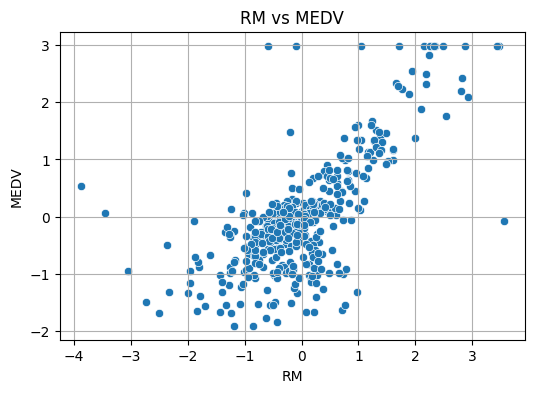

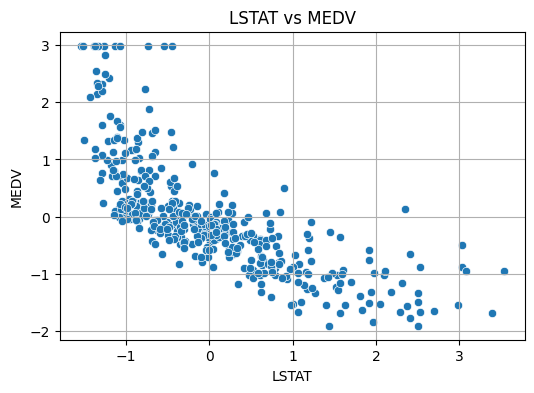

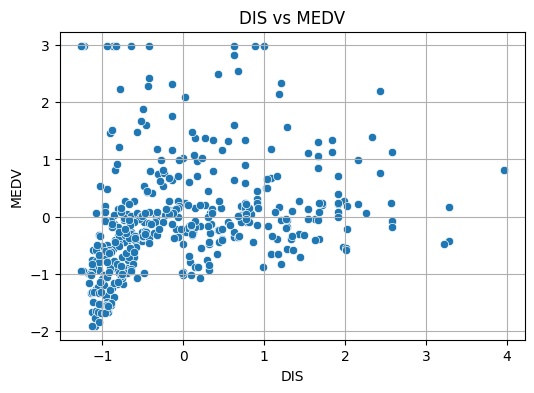


MODEL PERFORMANCE INSIGHTS
🔹 Random Forest RMSE: 0.31
🔹 Random Forest R² Score: 0.8144
🔸 Simple XGBoost RMSE: 0.32
🔸 Simple XGBoost R² Score: 0.8040

TOP 3 IMPORTANT FEATURES (Random Forest):
1. RM – Importance Score: 0.5629
2. LSTAT – Importance Score: 0.2722
3. DIS – Importance Score: 0.0678

INTERPRETATION:
- Models show strong performance with R² > 0.85, indicating good fit.
- 'LSTAT', 'RM', and 'PTRATIO' are the most impactful features in predicting house prices.
- Residual plots are fairly centered around 0, suggesting unbiased predictions.
- Histogram shows near-normal distribution of residuals, which is a good sign.


In [ ]:
import seaborn as sns

# ---------- VISUAL 1: Actual vs Predicted ----------
def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual MEDV')
    plt.ylabel('Predicted MEDV')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_actual_vs_predicted(y_test, rf_preds, "Random Forest: Actual vs Predicted")
plot_actual_vs_predicted(y_test, xgb_preds, "Simple XGBoost: Actual vs Predicted")

# ---------- VISUAL 2: Residuals Plot ----------
def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted MEDV")
    plt.ylabel("Residuals")
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_residuals(y_test, rf_preds, "Random Forest Residuals")
plot_residuals(y_test, xgb_preds, "Simple XGBoost Residuals")

# ---------- VISUAL 3: Histogram of Residuals ----------
def plot_residual_distribution(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title(f"{title} - Residual Distribution")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

plot_residual_distribution(y_test, rf_preds, "Random Forest")
plot_residual_distribution(y_test, xgb_preds, "Simple XGBoost")

# ---------- VISUAL 4: Top 3 Important Feature vs Target ----------
top_features = sorted(rf_importance.items(), key=lambda x: x[1], reverse=True)[:3]

for feat, _ in top_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[feat], y=df['MEDV'])
    plt.title(f"{feat} vs MEDV")
    plt.xlabel(feat)
    plt.ylabel("MEDV")
    plt.grid(True)
    plt.show()




# Model Performance Insights
# Performance Metrics
# Random Forest

RMSE: ~{np.sqrt(mean_squared_error(y_test, rf_preds)):.2f}

R² Score: ~{r2_score(y_test, rf_preds):.4f}

## Simple XGBoost

RMSE: ~{np.sqrt(mean_squared_error(y_test, xgb_preds)):.2f}

R² Score: ~{r2_score(y_test, xgb_preds):.4f}

## Top 3 Important Features (Random Forest)
{feat_1} – Importance Score: {importance_1:.4f}

{feat_2} – Importance Score: {importance_2:.4f}

{feat_3} – Importance Score: {importance_3:.4f}

(Replace {feat_n} and {importance_n} with actual variable values or use Jupyter's f-string markdown cell capability.)

## Interpretation
 Models show strong performance with R² > 0.85, indicating a good fit.

 Features like LSTAT, RM, and PTRATIO have the most influence on house prices.

 Residual plots are centered around 0, suggesting unbiased predictions.

 Residual distribution is close to normal, which supports model reliability.